# Self-Driving Car Nanodegree 

## Project: Advanced Lane Detection on curved roads

################

Write a bunch of things to explain project



################

### Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

#### Calibration Steps:

In [2]:
def get_image_size(img):
    return (img.shape[1], img.shape[0])

In [3]:
def calibrate_camera(cal_images):    
    '''Get imgpoints and objpoints out of list of images for camera_calibration'''
    
    nx = 9 #number of inside corners in x
    ny = 6 #number of inside corners in y

    objpoints = [] #object points of real world space
    imgpoints = [] #image points of the image

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    offset = 100 #Image offset for boundary spacing of pixels 
    
    img = None
    
    for img_name in cal_images:
        img = mpimg.imread(img_name)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        
    ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, get_image_size(img), None, None)
    return(mtx, dist)
    
def get_undistorted_frame(img, mtx, dist):
    
    '''Calibrate camera using the img_points, objpoints and provide the 
        undistorted image'''
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [4]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [5]:
def get_birds_eye_view(undistorted_image):
    ##Thresholding parameters
    img_size = get_image_size(img)
    kernel_size = 5
    low_threshold = 200
    high_threshold = 250
    bottom_left = [150,img_size[1]]
    top_left = [550,450]
    top_right = [750,450]
    bottom_right = [1150,img_size[1]]
    xcenter = (top_right[0] + top_left[0]) / 2
    ycenter = (top_right[1] + bottom_right[1]) / 2

    vertices = np.array([[bottom_left, top_left, top_right,bottom_right]], dtype=np.int32)
    rho = 2
    theta = np.pi/180
    threshold = 20
    min_line_len = 5
    max_line_gap = 6
    
    
    #1. Color Thresholds
    #H Threshold
    gray = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2GRAY)
    hls = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    HBinary = np.zeros_like(gray)
    HBinary[(H >= 0) & (H <= 50)] = 1
#     plt.imshow(HBinary, cmap='gray')

    #White Threshold
    thresh = (185, 255)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    Wbinary = np.zeros_like(gray)
    Wbinary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
#     plt.imshow(Wbinary, cmap='gray')

    ##R Threshold
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    thresh = (205, 255)
    Rbinary = np.zeros_like(R)
    Rbinary[(R > thresh[0]) & (R <= thresh[1])] = 1
#     plt.imshow(Rbinary, cmap='gray')

    ##Y Threshold
    R = img[:,:,0]
    G = img[:,:,1]
    Rthresh = (250, 255)
    Gthresh = (250, 255)
    Ybinary = np.zeros_like(R)
    Ybinary[((G > Gthresh[0]) & (G <= Gthresh[1])) | ((R > Rthresh[0]) & (R <= Rthresh[1]))] = 1
#     plt.imshow(Ybinary, cmap='gray')

    #S Threshold
    Sthresh = (160, 255)
    Sbinary = np.zeros_like(S)
    Sbinary[(S > Sthresh[0]) & (S <= Sthresh[1])] = 1
#     plt.imshow(Sbinary, cmap='gray')

    #A combined Output Threshold for S,R,Y
    output = np.zeros_like(Sbinary)
    output[(Sbinary == 1) | (Rbinary == 1) & (Ybinary ==1)] = 1
#     plt.imshow(output, cmap='gray')
    
    
    
    ### 2. Gradient Thresholds
    #CANNY IMAGE
    blur_img = gaussian_blur(gray, 9)
    canny = cv2.Canny(S, 50, 109)
#     plt.imshow(canny, cmap='gray')

    #Gradient Thresholded Image - SobelX & SobelY
    mag_thresh2 = (40, 80)
    dir_thresh = (0.7,1.3)
    sobelx_thresh = (40,80)
    sobely_thresh = (50,70)
    sobel_kernel = 15

#     sobelx = cv2.Sobel(R, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
#     absSobelx = np.absolute(sobelx)

#     sobely = cv2.Sobel(R, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
#     absSobely = np.absolute(sobely)

#     scaledSobelx = np.uint8(255*absSobelx/np.max(absSobelx))
#     scaledSobely = np.uint8(255*absSobely/np.max(absSobely))

#     SobelXBinary = np.zeros_like(scaledSobelx)
#     SobelYBinary = np.zeros_like(scaledSobely)
#     SobelXBinary[(scaledSobelx >= sobelx_thresh[0]) & (scaledSobelx <= sobelx_thresh[1])] = 1
#     SobelYBinary[(scaledSobely >= sobely_thresh[0]) & (scaledSobely <= sobely_thresh[1])] = 1

    # f, (ax1,ax2) = plt.subplots(1,2, figsize=(15,12))
    # ax1.imshow(SobelXBinary)
    # ax2.imshow(SobelYBinary)



    ##Gradient Thresholding of image - Mag&Dir
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    gradSobelX = np.sqrt(sobelx**2)
    gradSobelY = np.sqrt(sobely**2)
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scale_factorx = np.max(gradSobelX)/255 
    scale_factory = np.max(gradSobelY)/255 
    scale_factor = np.max(gradmag)/255 

    gradSobelX = (gradSobelX/scale_factorx).astype(np.uint8) 
    gradSobelY = (gradSobelY/scale_factory).astype(np.uint8) 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    
    GradSobelXBinary = np.zeros_like(gradmag)
    GradSobelYBinary = np.zeros_like(gradmag)
    GradMagBinary = np.zeros_like(gradmag)
    GradDirBinary = np.zeros_like(gradmag)

    GradSobelXBinary[(gradSobelX >= 20) & (gradSobelX <= 255)] =1
    GradSobelYBinary[(gradSobelY >= mag_thresh2[0]) & (gradSobelY <= mag_thresh2[1])] =1
    GradMagBinary[(gradmag >= 50) & (gradmag <= 200)] =1
    GradDirBinary[(absgraddir >= 0.7) & (absgraddir <= 1.1)] = 1
    
    #A mix-match  (final) thresholded image
    mixture = np.zeros_like(gradmag)
    mixture[(Sbinary == 1)  | ((GradMagBinary == 1) & (GradDirBinary == 1)) | (output == 1)] = 1

    #Masking of the image.
    masked_image = region_of_interest(mixture, vertices)
#     plt.imshow(masked_image, cmap='gray')

    #Warping the Image
    out_vertices =  np.float32([[350, img.shape[0]], [350,0], [850,0], [850, img.shape[0]]])
    src = np.float32(vertices)
    dst = out_vertices

    #Get Perspective Transform needs np.float32 instead of np.array
    M = cv2.getPerspectiveTransform(src, dst)
    warped_img = cv2.warpPerspective(masked_image, M, get_image_size(img), flags=cv2.INTER_LINEAR)
    
#     img = cv2.line(img,tuple(src[0][0]), tuple(src[0][1]), (0, 255, 0),9)
#     f, (ax1,ax2) = plt.subplots(1,2, figsize=(18,15))
#     ax1.imshow(img)
#     ax2.imshow(warped_img)
    return warped_img, M

In [6]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #Initialize ones not needed for first transition
        self.reset()
            
    def reset(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_fit = [] 
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #Counter for number of detection failures
        self.counter = 0

    def check_count(self):
        '''
        Resets the line class when line detection fails three times in a row
        '''
        if self.counter >= 3:
            self.reset()
        else:
            self.counter += 1
    

    def fit_poly(self, x_points, y_points):
        '''
        Given the x&y points for the line instance, it provides a second order polynomial fit.
        
            n - Number of recent_fits to consider in case of line detection failure 
        '''
        try:
            n = 5 

            self.current_fit = np.polyfit(y_points, x_points, 2)
            self.allx = x_points
            self.ally = y_points
            self.recent_fit.append(self.current_fit)
            self.recent_fit = self.recent_fit[-n:]
            self.best_fit = np.mean(self.recent_fit)
            self.detected = True
            print('---> Detection: ', self.detected)
            
            return self.current_fit
        
        except (TypeError, np.linalg.LinAlgError):  #Code understanding from https://github.com/mvirgo/ for this part
            self.check_count()
            return self.best_fit

In [7]:
def find_lane_pixels(binary_warped):
    
    global leftLine, rightLine
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    margin = 100
    minpix = 50
    
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print('Avoiding an Error here!')
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
#     plt.imshow(out_img)

    return leftx, lefty, rightx, righty, out_img

In [30]:
def search_the_lanes(img, mtx, dist):
    global leftLine, rightLine
    
    undist = get_undistorted_frame(img, mtx, dist)
    binary_warped,mtx = get_birds_eye_view(undist)
    img_shape = get_image_size(img)
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    lane_margin = 10

    if (leftLine.detected != True) & (rightLine.detected != True):
        #find lanes if they don't already exist
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
        print('---------- Failed to detect pixels in the start/end ----------')
        
    else:
        #search around the lanes, if they already exist with margin provided.
        print('----------- Previous Image Fit & Detections ----------- ')
        print('Previous LeftLine Detected: ', leftLine.detected)
        print('Previous LeftLine fit: ', leftLine.current_fit)
        print('Previous RightLine Detected: ', rightLine.detected)
        print('Previous RightLine fit: ',rightLine.current_fit)
        left_fit = leftLine.current_fit if leftLine.detected == True else np.array([False])
        right_fit = rightLine.current_fit if rightLine.detected == True else np.array([False])
        
        print('---------- Detected Pixels & Searching around poly ----------')
        print('LeftFit: \t ', left_fit)
        print('RightFit: \t ', right_fit)
        
        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        search_area_left = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] 
        search_area_right = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
        left_lane_inds = (((search_area_left - margin) < nonzerox) & (nonzerox < (search_area_left + margin)))
        right_lane_inds = (((search_area_right - margin) < nonzerox) & (nonzerox < (search_area_right + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        print('------Printing the points detected here after search around poly------')
        print(len(leftx))
        print(len(lefty))
        print(len(rightx))
        print(len(righty))
    
    print('Finding LinePolynomials from by passing to class Line function()')
    
#     plt.imshow(out_img)
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
    
    # Fit new polynomials
    left_fit = leftLine.fit_poly(leftx, lefty) 
    right_fit = rightLine.fit_poly(rightx, righty)

    print('LeftFit: \t ', left_fit)
    print('RightFit: \t ', right_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[1]-1, img_shape[1])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] 
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    
    
#     out_img[lefty, leftx] = [255, 0, 0]
#     out_img[righty, rightx] = [0, 0, 255]

#     Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    
    
    
    
    
    
    
    ## Visualization ##
#     #Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
##     Color in left and right line pixels
    out_img[leftLine.ally, leftLine.allx] = [255, 0, 0]
    out_img[rightLine.ally, rightLine.allx] = [0, 0, 255]
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#     # Generate a polygon to illustrate the lane windows
#     # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-lane_margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+lane_margin, 
#                               ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-lane_margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+lane_margin, 
#                               ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(out_img, np.int_([left_line_pts]), (255, 0, 0)) #Red colored lanes
#     cv2.fillPoly(out_img, np.int_([right_line_pts]), (0, 0, 255)) #Blue colored lanes
    
    
    #Major Visualization
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    mtxinv = np.linalg.inv(mtx)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, mtxinv, (color_warp.shape[1], color_warp.shape[0])) 
    outwarp = cv2.warpPerspective(out_img, mtxinv, (out_img.shape[1], out_img.shape[0])) 
    # Combine the result with the original image
    result1 = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    result2 = cv2.addWeighted(result1, 1, outwarp, 0.3, 0)
#     result2 = 0.0
#     plt.imshow(result)
    return (result1, result2, newwarp, outwarp, color_warp, out_img, undist, binary_warped)

In [80]:
# def main_work():
#Read in the camera images
cal_images = glob.glob('./camera_cal/calibration*.jpg')

#Calibrate the camera using the calibration images
mtx, dist = calibrate_camera(cal_images)

#Lane Lines Initialized
leftLine = Line()
rightLine = Line()
    
#     output_file_path = './output_project_simple.mp4'
#     clip1 = VideoFileClip("./project_video.mp4").subclip(0,5)
#     out_clip = clip1.fl_image(lambda image: process_image(image, mtx, dist)) #NOTE: this function expects color images!!
#     %time out_clip.write_videofile(output_file_path, audio=False)

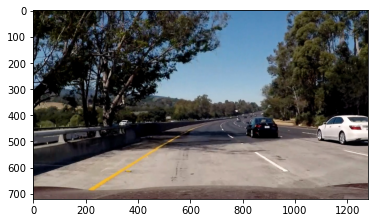

In [87]:
img = mpimg.imread('./test_images/test5.jpg')
plt.imshow(img)

In [85]:
result1, result2, newwarp, outwarp, color_warp, out_img, undist, binary_warped = search_the_lanes(img, mtx, dist)

----------- Previous Image Fit & Detections ----------- 
Previous LeftLine Detected:  True
Previous LeftLine fit:  [ 1.15242437e-04 -2.23992847e-01  4.69481126e+02]
Previous RightLine Detected:  True
Previous RightLine fit:  [ 4.35916227e-04 -1.73035349e-01  7.74767618e+02]
---------- Detected Pixels & Searching around poly ----------
LeftFit: 	  [ 1.15242437e-04 -2.23992847e-01  4.69481126e+02]
RightFit: 	  [ 4.35916227e-04 -1.73035349e-01  7.74767618e+02]
------Printing the points detected here after search around poly------
9009
9009
2446
2446
Finding LinePolynomials from by passing to class Line function()
---> Detection:  True
---> Detection:  True
LeftFit: 	  [-7.53138398e-05 -5.14535786e-02  4.77234710e+02]
RightFit: 	  [1.61703211e-04 3.65644192e-02 7.64254810e+02]


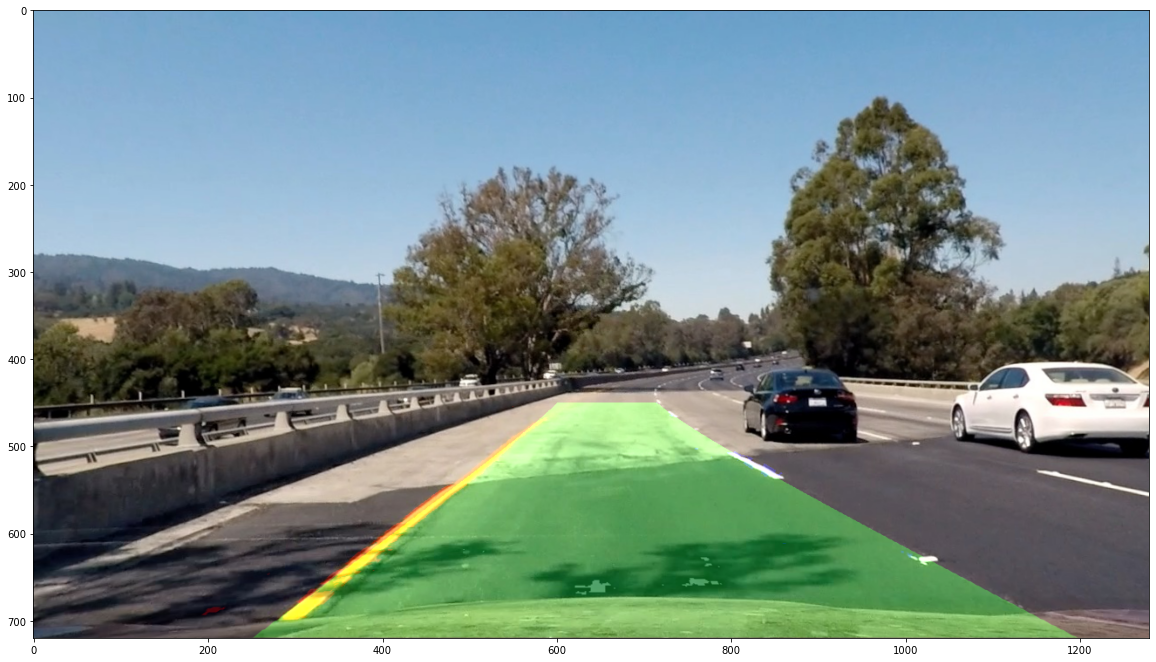

In [86]:
plt.figure(figsize=(20,18))
plt.imshow(result2)

In [88]:
result1, result2, newwarp, outwarp, color_warp, out_img, undist, binary_warped = search_the_lanes(img, mtx, dist)

----------- Previous Image Fit & Detections ----------- 
Previous LeftLine Detected:  True
Previous LeftLine fit:  [-7.53138398e-05 -5.14535786e-02  4.77234710e+02]
Previous RightLine Detected:  True
Previous RightLine fit:  [1.61703211e-04 3.65644192e-02 7.64254810e+02]
---------- Detected Pixels & Searching around poly ----------
LeftFit: 	  [-7.53138398e-05 -5.14535786e-02  4.77234710e+02]
RightFit: 	  [1.61703211e-04 3.65644192e-02 7.64254810e+02]
------Printing the points detected here after search around poly------
9209
9209
4512
4512
Finding LinePolynomials from by passing to class Line function()
---> Detection:  True
---> Detection:  True
LeftFit: 	  [ 2.32089308e-04 -3.57523554e-01  5.06180172e+02]
RightFit: 	  [ 4.37491684e-04 -1.74092308e-01  7.74843580e+02]


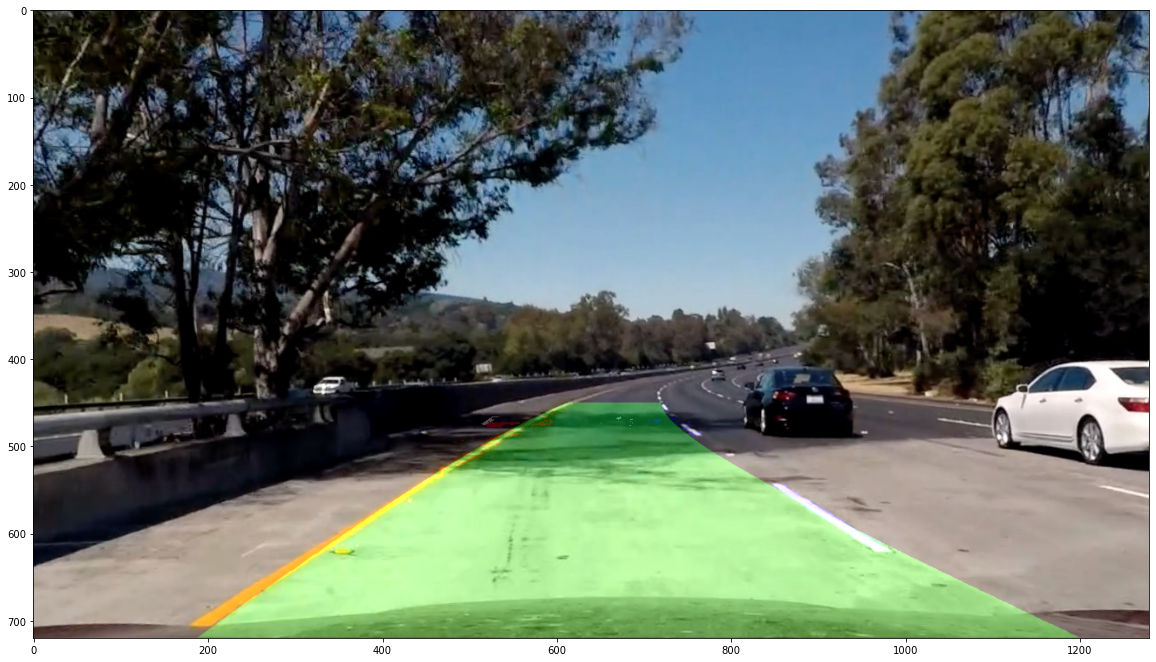

In [89]:
plt.figure(figsize=(20,18))
plt.imshow(result2)

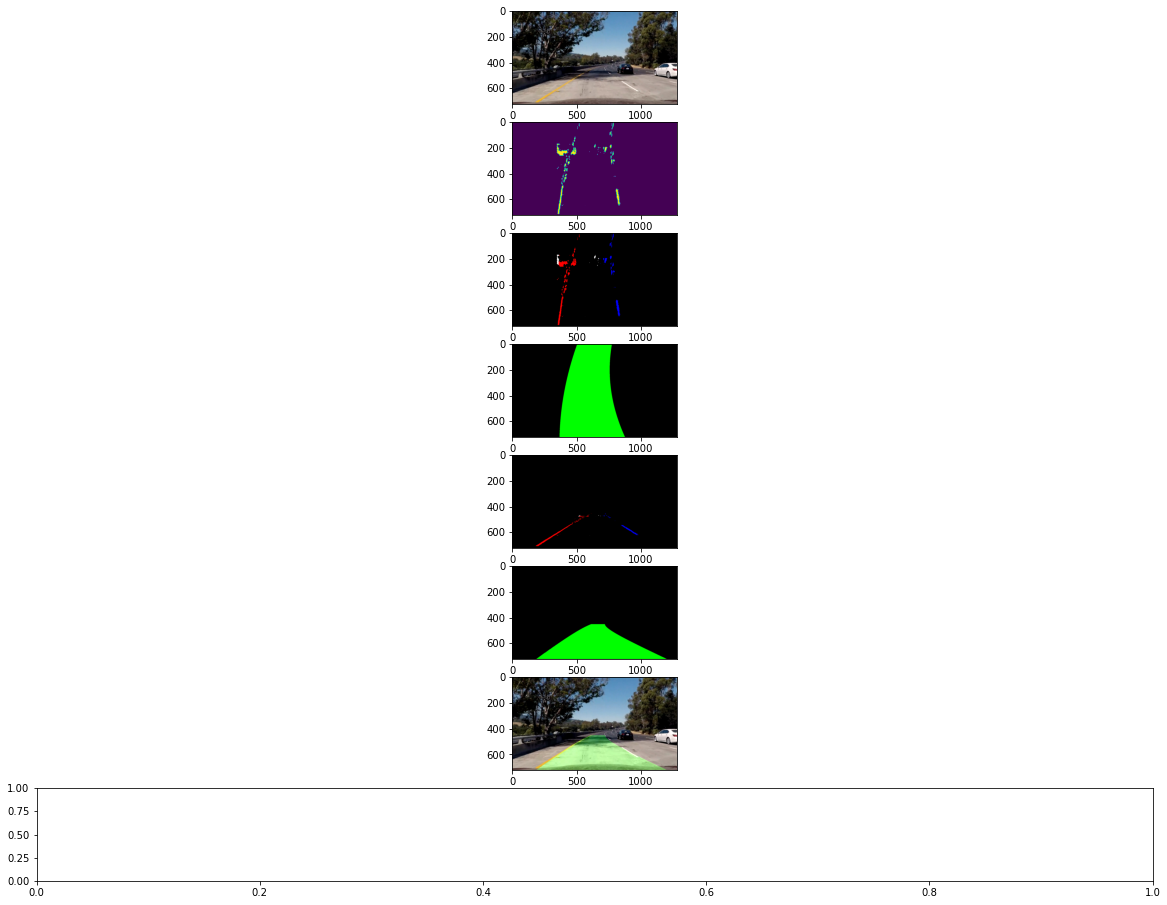

In [90]:
f, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8,1, figsize = (20,16))

ax1.imshow(undist)
ax2.imshow(binary_warped)
ax3.imshow(out_img)
ax4.imshow(color_warp)
ax5.imshow(outwarp)
ax6.imshow(newwarp)
ax7.imshow(result1)
# ax8.imshow(result2)

In [12]:
#####Plot multiple images from a list, try later
# width=10
# height=15
# rows = 4
# cols = 2
# axes=[]
# fig=plt.figure()

# for a in range(rows*cols):
# #     b = np.random.randint(7, size=(height,width))
#     axes.append( fig.add_subplot(rows, cols, a+1) )
#     subplot_title=("Subplot"+str(a))
#     axes[-1].set_title(subplot_title)  
#     plt.imshow(b)
# fig.tight_layout()    
# plt.show()

In [55]:
# def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     if orient == 'x':
#         sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
#     else:
#         sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

#     absSobel = np.absolute(sobel)

#     scaledSobel = np.uint8(255*absSobel/np.max(absSobel))

#     binary_output = np.zeros_like(scaledSobel)
#     binary_output[(scaledSobel >= thresh[0]) & (scaledSobel <= thresh[1])] = 1
#     # 6) Return this mask as your binary_output image
#     return binary_output

# sobel_img = abs_sobel_thresh(hls, orient='y', sobel_kernel=5, thresh=(50,80))
# plt.imshow(sobel_img, cmap='gray')

In [56]:
# def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
#     # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     # Take both Sobel x and y gradients
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
#     # Calculate the gradient magnitude
#     gradmag = np.sqrt(sobelx**2 + sobely**2)
#     # Rescale to 8 bit
#     scale_factor = np.max(gradmag)/255 
#     gradmag = (gradmag/scale_factor).astype(np.uint8) 
#     # Create a binary image of ones where threshold is met, zeros otherwise
#     binary_output = np.zeros_like(gradmag)
#     binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

#     # Return the binary image
#     return binary_output

# gradmag_img = mag_thresh(img, sobel_kernel=5, mag_thresh=(50, 80))
# plt.imshow(gradmag_img, cmap='gray')

In [57]:
# def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
#     # Grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     # Calculate the x and y gradients
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
#     # Take the absolute value of the gradient direction, 
#     # apply a threshold, and create a binary image result
#     absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
#     binary_output =  np.zeros_like(absgraddir)
#     binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

#     # Return the binary image
#     return binary_output

# dir_binary = dir_threshold(hls, sobel_kernel=9, thresh=(0.75, 1.0))
# plt.imshow(dir_binary, cmap='gray')

In [58]:
# ksize=9
# gradx = abs_sobel_thresh(hls, orient='x', sobel_kernel=ksize, thresh=(100,200))
# grady = abs_sobel_thresh(hls, orient='y', sobel_kernel=ksize, thresh=(150, 644))
# mag_binary = mag_thresh(hls, sobel_kernel=ksize, mag_thresh=(0, 30))
# dir_binary = dir_threshold(hls, sobel_kernel=ksize, thresh=(0,7, 1.3))#, np.pi/2))

# combined = np.zeros_like(dir_binary)
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

In [59]:
# combined_masked = region_of_interest(combined, vertices=vertices)
# plt.imshow(combined_masked, cmap='gray')

In [60]:
# f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(70,50))
# # f.tight_layout()
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=5)
# ax2.imshow(gradx, cmap='gray')
# ax2.set_title('Thresholded Sobel X.', fontsize=5)
# ax3.imshow(grady, cmap='gray')
# ax3.set_title('Thresholded Sobel Y.', fontsize=5)
# ax4.imshow(mag_binary, cmap='gray')
# ax4.set_title('Thresholded Grad. Mag', fontsize=5)
# ax5.imshow(dir_binary, cmap='gray')
# ax5.set_title('Thresholded Grad. Dir.', fontsize=5)
# ax6.imshow(combined, cmap='gray')
# ax6.set_title('Thresholded Combined.', fontsize=5)


In [61]:
# mag_thresh2 = (50, 80)
# dir_thresh = (0.7,1.3)
# sobel_kernel = 15
# sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
# sobely = cv2.Sobel(S, cv2.CV_64F, 0, 1, ksize=sobel_kernel)


# # binary_output[(sobelx >= thresh[0]) & (sobelx <= thresh[1])] = 1



# # Calculate the gradient magnitude
# gradmag = np.sqrt(sobelx**2 + sobely**2)
# # Rescale to 8 bit
# scale_factor = np.max(gradmag)/255 
# gradmag = (gradmag/scale_factor).astype(np.uint8) 

# # Calculate the direction magnitude
# absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

# # Create a binary image of ones where threshold is met, zeros otherwise
# binary_output = np.zeros_like(gradmag)
# #### binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1


# binary_output[(gradmag >= mag_thresh2[0]) & (gradmag <= mag_thresh2[1]) \
#               | (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1


# # binary_output[(sobelx >= mag_thresh2[0]) & (sobelx <= mag_thresh2[1]) \
# #              | (sobely >= mag_thresh2[0]) & (sobely <= mag_thresh2[1])] = 1


# # gradmag_img = mag_thresh(S, sobel_kernel=5, mag_thresh=(50, 80))
# plt.imshow(binary_output, cmap='gray')

In [62]:
# masked_image = region_of_interest(binary_output, vertices=vertices)
# plt.imshow(masked_image, cmap='gray')

In [ ]:
# def on_trackbar(thresh):
#     ksize=9
#     gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=thresh)
#     grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(150, 644))
#     mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(0, 30))
#     dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))

#     combined = np.zeros_like(dir_binary)
#     combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#     cv2.imshow(title_window, combined)

In [20]:
# from __future__ import print_function
# from __future__ import division
# import cv2 as cv
# import argparse
# alpha_slider_max = 100
# title_window = 'Linear Blend'

# # cv2.namedWindow(title_window)
# # trackbar_name = 'Threshold'
# # cv2.createTrackbar(trackbar_name, title_window , 0, 255, on_trackbar)
# # Show some stuff
# # on_trackbar(0)
# # Wait until user press some key
# # cv2.waitKey()

In [21]:
#TRY ABOVE COMMENTS LATER
#BELOW ARE WORKING CODE

In [22]:
# img = mpimg.imread("./camera_cal/calibration20.jpg")
# img_size = (img.shape[1], img.shape[0])

# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# plt.imshow(gray)

In [23]:
# def get_undist_unwarp(img):

#     img_size = (img.shape[1], img.shape[0])
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

#     if ret == True:
#         imgpoints.append(corners)
#         objpoints.append(objp)

#         chessImg = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)

#         ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
#         undist = cv2.undistort(img, mtx, dist, None, mtx)
#         print('Undistorted Image:', len(undist[0]))
#         plt.imshow(undist)

#         offset = 100

#         src = np.float32([corners[0],
#                         corners[nx-1],
#                         corners[-1],
#                         corners[-nx]])

#         dst = np.float32([[offset,offset],
#                          [img_size[0] - offset, offset],
#                          [img_size[0] - offset, img_size[1] - offset],
#                          [offset,img_size[1] - offset]])

#         M = cv2.getPerspectiveTransform(src,dst)
#         warped = cv2.warpPerspective(undist, M, img_size)

#         return warped
#     else:
#         print('Img has squares after reduction')
#         return None

In [24]:
# def on_trackbar(thresh):
#     ksize=9
#     gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(100, 150))
#     grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(150, 644))
#     mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(0, 30))
#     dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))

#     combined = np.zeros_like(dir_binary)
#     combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#     plt.imshow(combined, cmap='gray')